In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
DIRECTORY = "D:/Nachiket/Stuff/dataset"
CATEGORIES = ["with mask", "without mask"]

epochs_value=20
BS=32
data = []
target = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
       	img_path = os.path.join(path, img)
       	image = load_img(img_path, target_size=(224, 224, 3), color_mode='rgb')
       	image = img_to_array(image)
        image = preprocess_input(image)    
        data.append(image)
       	target.append(category)

## labeling the target values
lb = LabelBinarizer() 
target = lb.fit_transform(target)
target = to_categorical(target)

data = np.array(data, dtype="float32")
target = np.array(target)

In [3]:
from sklearn.model_selection import train_test_split
(train_data,test_data,train_target,test_target)=train_test_split(data,target,test_size=0.2, stratify=target, random_state=42)


from keras_preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
 	rotation_range=20,
 	zoom_range=0.20,
 	width_shift_range=0.2,
 	height_shift_range=0.2,
 	shear_range=0.15,
 	horizontal_flip=True,
 	fill_mode="nearest")


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D


from tensorflow.keras.optimizers import SGD
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='sigmoid'))
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


H=model.fit(
    aug.flow(train_data,train_target,batch_size=BS),
    steps_per_epoch=len(train_data)//BS,
    validation_data=(test_data,test_target),
    validation_steps=len(test_data)//BS,
    epochs=epochs_value)

Epoch 1/20
34/34 [==============================] - 27s 771ms/step - loss: 1.1403 - accuracy: 0.6742 - val_loss: 0.4783 - val_accuracy: 0.6739
Epoch 2/20
34/34 [==============================] - 24s 711ms/step - loss: 0.5031 - accuracy: 0.6903 - val_loss: 0.2432 - val_accuracy: 0.9167
Epoch 3/20
34/34 [==============================] - 25s 728ms/step - loss: 0.4019 - accuracy: 0.8375 - val_loss: 0.1834 - val_accuracy: 0.9348
Epoch 4/20
34/34 [==============================] - 27s 805ms/step - loss: 0.3657 - accuracy: 0.8420 - val_loss: 0.1374 - val_accuracy: 0.9420
Epoch 5/20
34/34 [==============================] - 27s 782ms/step - loss: 0.3182 - accuracy: 0.8620 - val_loss: 0.1639 - val_accuracy: 0.9457
Epoch 6/20
34/34 [==============================] - 27s 785ms/step - loss: 0.3179 - accuracy: 0.8644 - val_loss: 0.1804 - val_accuracy: 0.9601
Epoch 7/20
34/34 [==============================] - 29s 855ms/step - loss: 0.2682 - accuracy: 0.8853 - val_loss: 0.1588 - val_accuracy: 0.9348

              precision    recall  f1-score   support

   with mask       0.92      0.99      0.95       138
without mask       0.98      0.91      0.95       138

    accuracy                           0.95       276
   macro avg       0.95      0.95      0.95       276
weighted avg       0.95      0.95      0.95       276



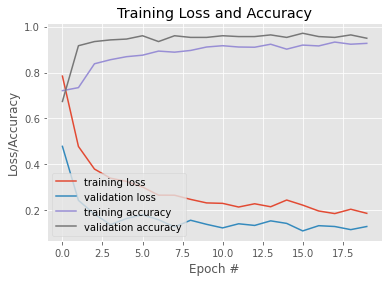

In [4]:
prediction = model.predict(test_data, batch_size=BS)
prediction = np.argmax(prediction, axis=1)



from sklearn.metrics import classification_report
print(classification_report(test_target.argmax(axis=1), prediction,
	target_names=lb.classes_))


model.save("Face_mask_detector.model", save_format="h5")

import matplotlib.pyplot as plt
N = epochs_value
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="training loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="validation loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="training accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [3]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import cv2


def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
        

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# load our serialized face detector model from disk
prototxtPath = r"D:\Nachiket\Stuff\face_detector\deploy.prototxt"
weightsPath = r"D:\Nachiket\Stuff\face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("Face_mask_detector.model")

# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 2

In [ ]:
if label == "No Mask":
            os.chdir(path)
            print("saved")
            framecopy = np.copy(frame)
            extracted = framecopy[startY:endY, startX:endX]
            cv2.imwrite(filename, extracted)
            os.chdir(base)
path = "D:/Nachiket/CodeFest/saved"
base = "C:/Users/nachi"
filename = 'savedImage.jpg'
os.chdir(base)